<a href="https://colab.research.google.com/github/Kim-TaeKyoung/ai_championship/blob/main/Blur_Validation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import json
import time

answer = '/content/drive/MyDrive/Colab/AI_ChampionShip/submission/gaussian_3_0.8_inference-20211101-042634-0.1-0.1-0.1- yolo&Effdet_bestscore56.json'
compare = '/content/drive/MyDrive/Colab/AI_ChampionShip/submission/gaussian_3_inference-20211101-093158-0.1-0.1-0.1-final.json'

answer_percent = 0.65

In [ ]:
# JSON의 모든 데이터 내 Scene을 비트 마스크의 형태로 변환한 Dictionary를 반환함
def unjson(target_json):
  return_dict = {}

  for key in target_json.keys():
    scenes = target_json[key]['scenes']
    list_max = int(target_json[key]['duration']) + 1

    return_dict.update({key : [0] * list_max})
    return_list = return_dict[key]

    for scene in scenes:
      for pivot in range(scene[0], scene[1] + 1):
        return_list[pivot] = 1

  return return_dict

In [ ]:
with open(answer, 'r') as f:
  answer_json = json.load(f)
  answer_unjson = unjson(answer_json)

with open(compare, 'r') as f:
  compare_json = json.load(f)
  compare_unjson = unjson(compare_json)

In [ ]:
# Key 일치 검증
for key in answer_json.keys():
  try:
    if compare_json[key] is None:
      print('mismatch')
  except:
    print('mismatch')

In [ ]:
count = 0
ious = 0

iou_list = []

for key in answer_json.keys():
  ansr = answer_json[key]['scenes']
  cmpr = compare_json[key]['scenes']

  b_ansr = answer_unjson[key]
  b_cmpr = compare_unjson[key]

  lefts = set([])
  rights = set([])

  n_lefts = set([])
  n_rights = set([])

  # 한번의 반복은 Compare Scene 하나의 배열 A를 정하고 모든 Answer Scene 배열 Bs에 대해
  # A 배열의 범위와 겹치는 모든 Bs_Match를 찾고 Bs_Match의 최왼단 위치 min(Bs_Match) = L와
  # 최오른단 위치 max(Bs_Match) = R를 구하고 Compare와 Answer의 비트 마스크 
  # 된 배열에서 범위 (L, R)의 True Positive, True Negative, False Positive, False Negative
  # 를 구하고 Union = TP + TN + FP + FN, Intersection = TP + TN를 각각 구해 IoU를 계산한다.

  # 발견되지 않는다면 겹치는 범위가 없기 때문에 [(intersection / union) = (0 / union) = 0]
  # count 만 올림

  # 모든 범위에 대해서 계산이 끝나면 IoU의 총합과 IoU 갯수로 나누어 정답지에 대한
  # IoU, Avg_C2A_IoU을 구한다.
  
  # Avg_C2A_IoU를 정답지의 정확도 answer_percent에 곱하여 전체 값에 대한 *예측*
  # 정확도를 구함.

  found = False

  if cmpr:
    tp = 0
    tn = 0
    fp = 0
    fn = 0

    for a in cmpr:
      l1 = a[0]
      r1 = a[1]

      if ansr:
        for c in ansr:
          l2 = c[0]
          r2 = c[1]

          if r1 < l2:
            continue
          elif r2 < l1:
            continue
          else:
            found = True
            lefts.add(l1)
            lefts.add(l2)
            rights.add(r1)
            rights.add(r2)
    
    union = 0
    intersection = 0

    if not found:
      iou = 0
      count += 1

    if lefts and rights and found:
      left_pivot = min(lefts)
      right_pivot = max(rights)

      # range는 i + 0 to i + n - 1 이기 때문에, right_pivot 프레임까지 
      # 포함하여 계산하기 위해 1을 더함
      for i in range(left_pivot, right_pivot + 1):
        ansr_p = b_ansr[i]
        cmpr_p = b_cmpr[i]

        if ansr_p == cmpr_p:
          if ansr_p:
            tp += 1
          else:
            tn += 1
        else:
          if ansr_p:
            fp += 1
          else:
            fn += 1
      
      union += tp + tn + fp + fn
      intersection += tp + tn
      
      iou = (intersection / union)
      ious += iou
      count += 1
  else:
    # Compare가 완전히 비어있으나 Answer는 값이 있을 경우, 완전히 틀린 것이기에 count 올림
    if ansr:
      iou = 0
      count += 1
    else:
    # 반대로 둘다 비어서 맞췄기때문에 [(intersection / union) = (? / ?) = 1] IoU = 1
      iou = 1
      ious += iou
  iou_list.append(iou)

print('Matching IoU :', ious / count)
print('Predicted Accuracy :', (ious / count) * answer_percent)

Matching IoU : 2.142857142857143
Predicted Accuracy : 1.3928571428571428


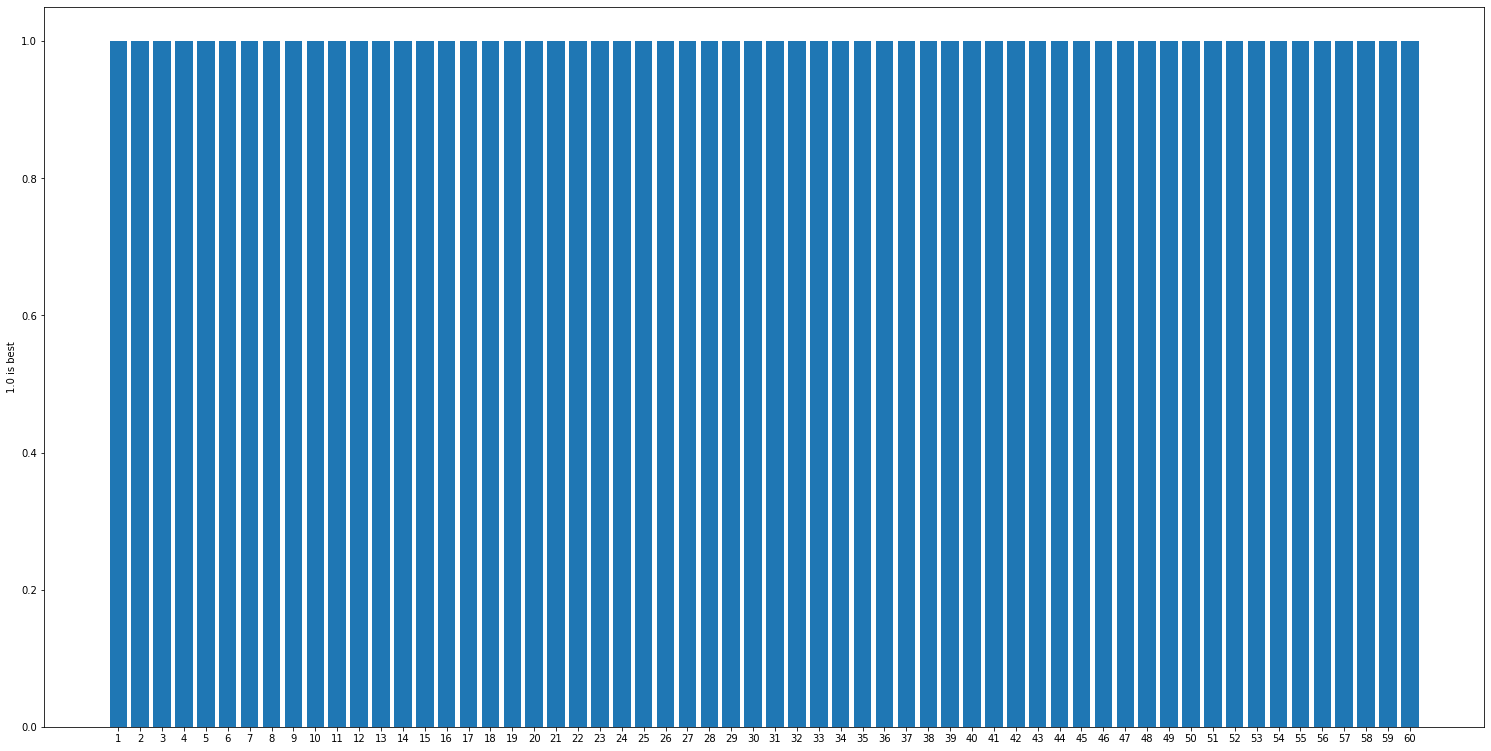

In [ ]:
# 딜그래프
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

labels = [i for i in range(1, len(answer_json.keys()) + 1)]
x = np.arange(1, len(labels) + 1)

fig = plt.figure(figsize=(20,10))
ax = fig.add_axes([0,0,1,1])
ax.bar(labels,iou_list)
ax.set_xticks(x)
plt.ylabel('1.0 is best') 
ax.set_xticklabels(labels)
plt.show()

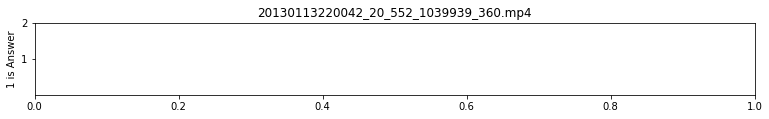

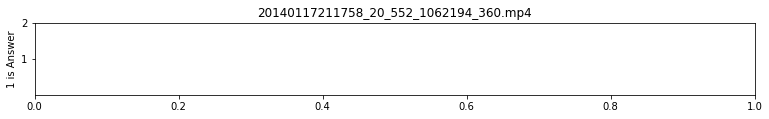

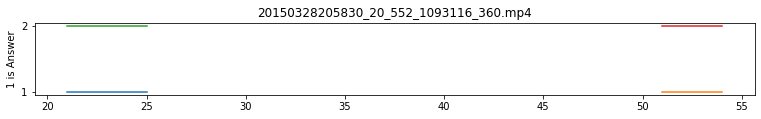

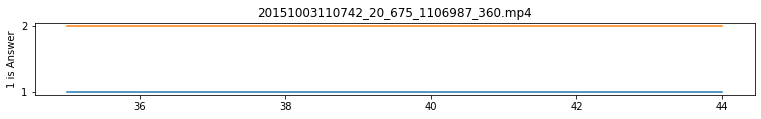

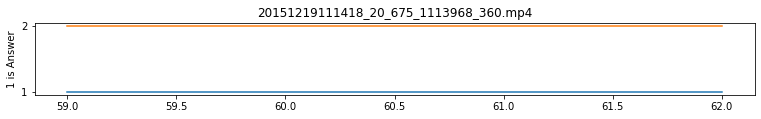

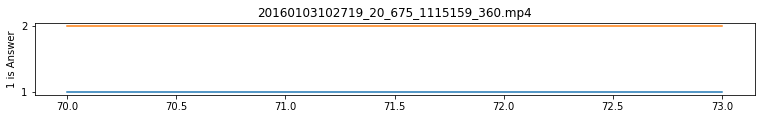

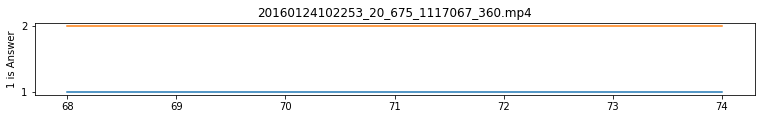

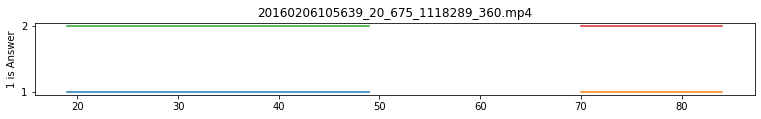

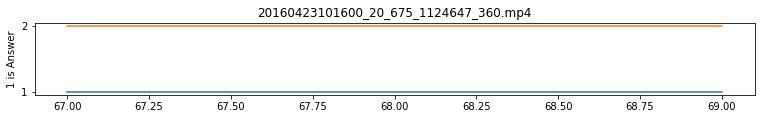

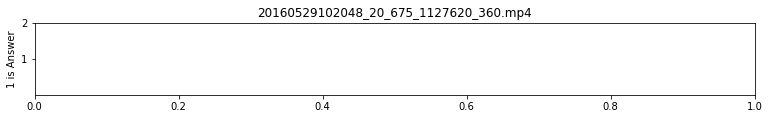

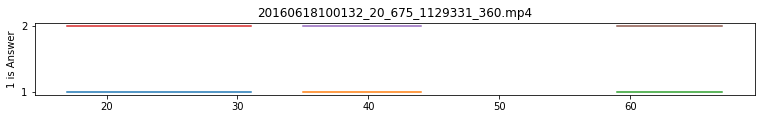

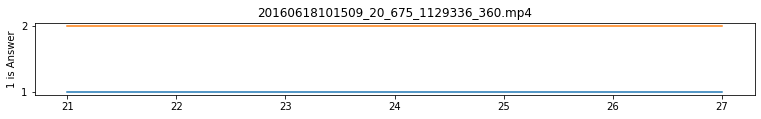

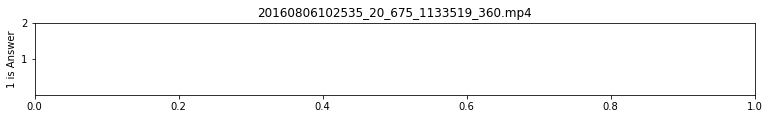

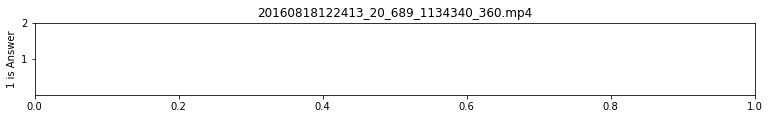

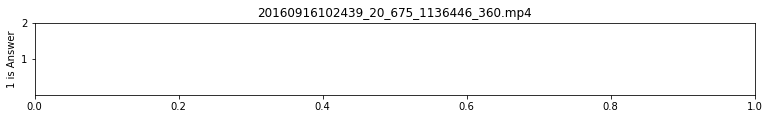

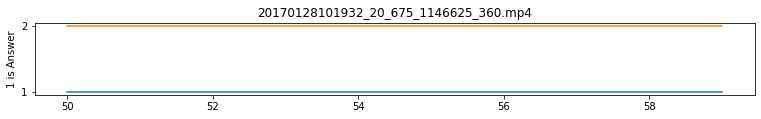

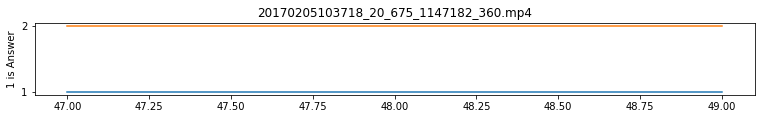

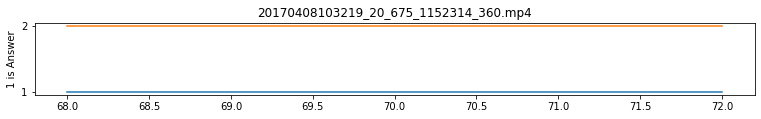

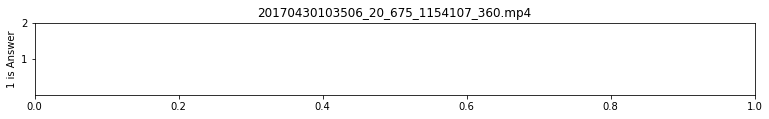

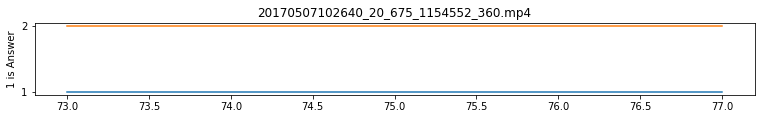

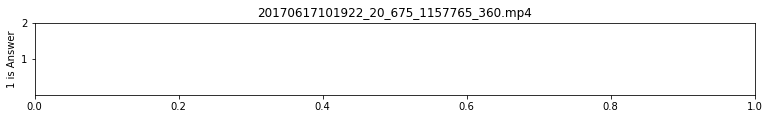

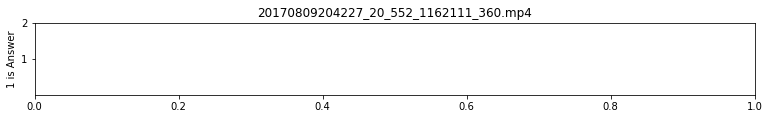

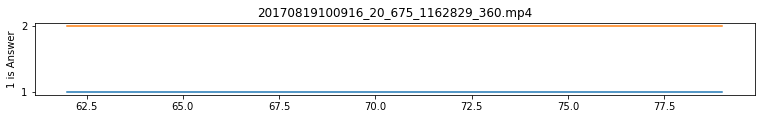

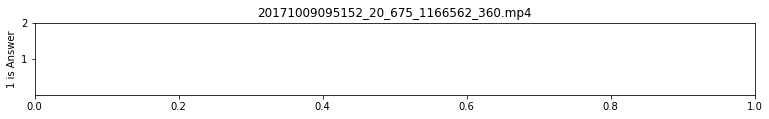

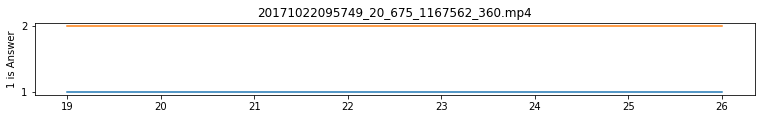

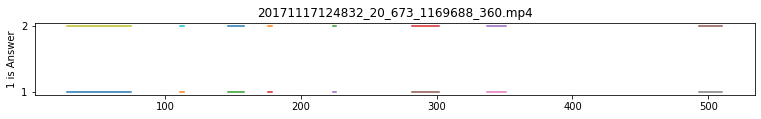

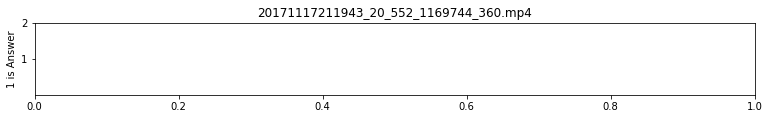

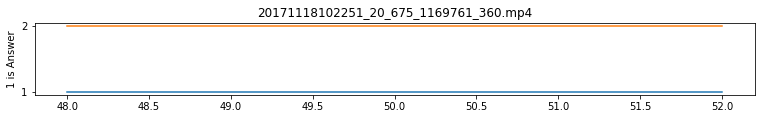

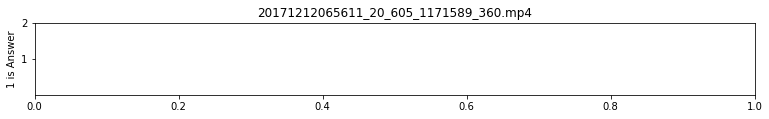

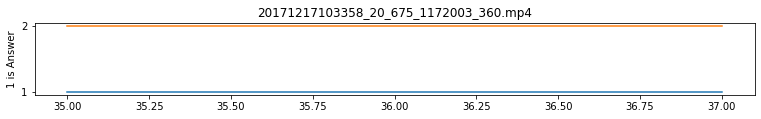

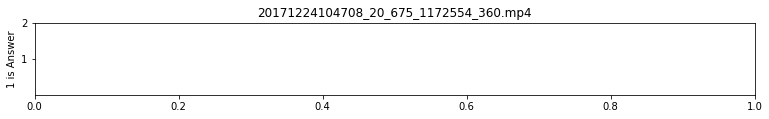

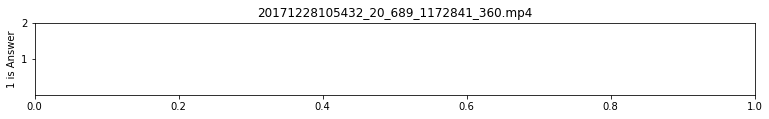

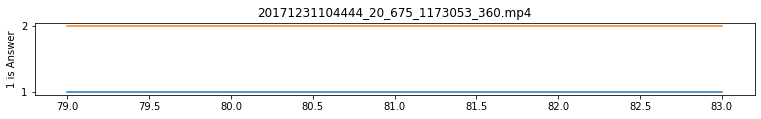

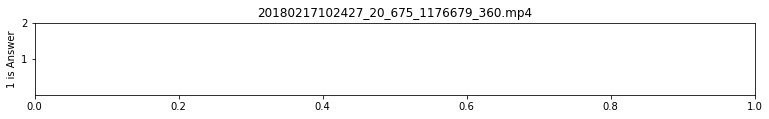

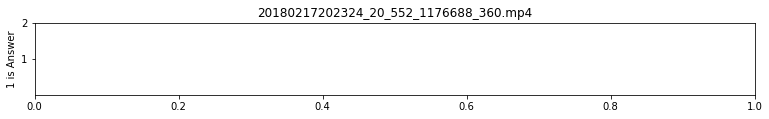

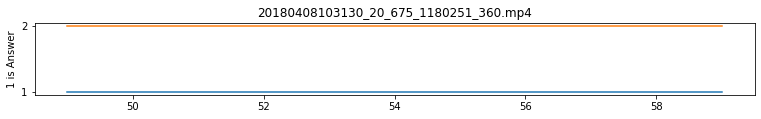

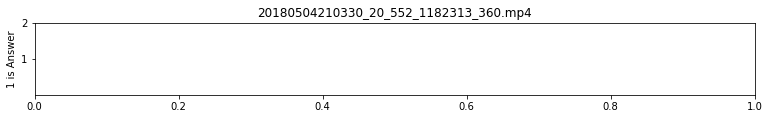

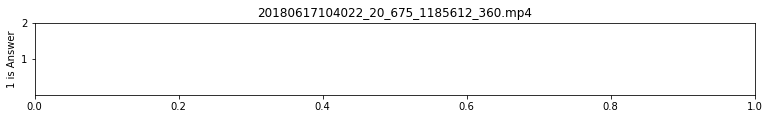

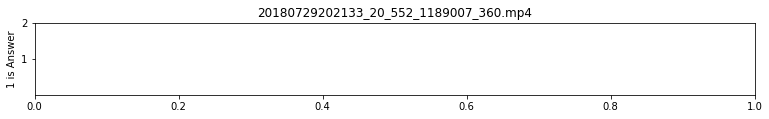

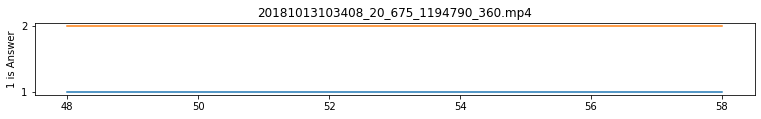

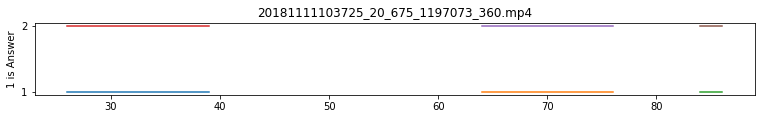

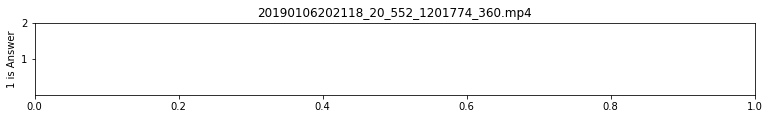

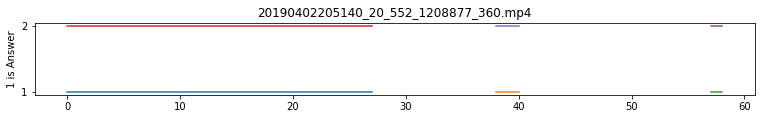

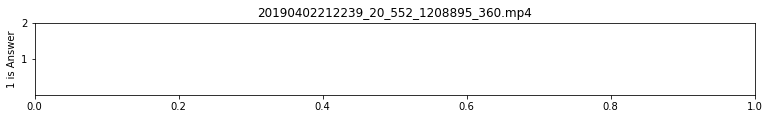

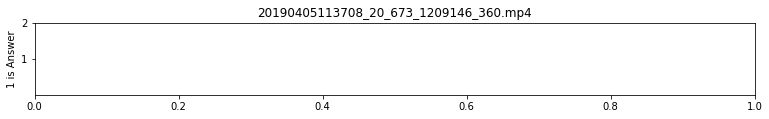

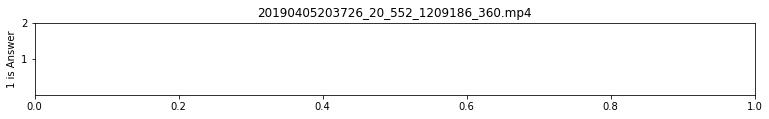

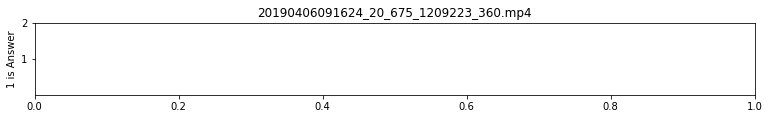

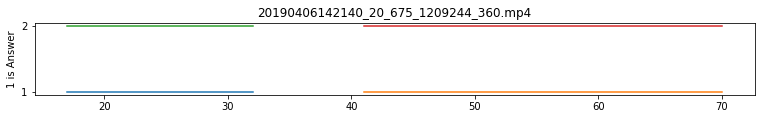

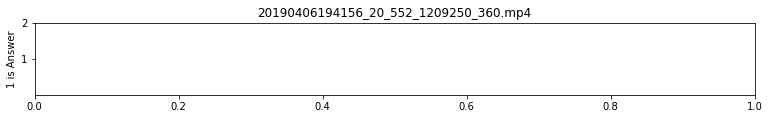

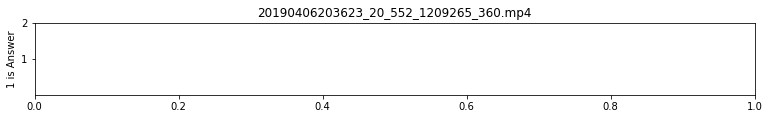

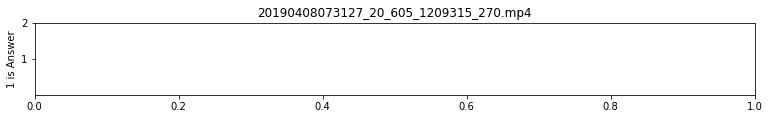

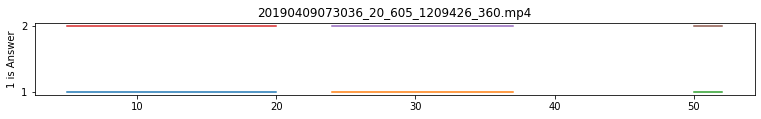

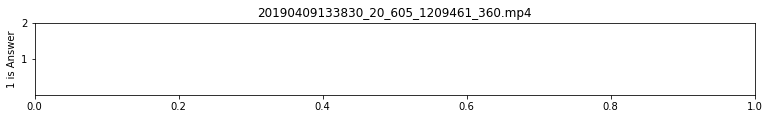

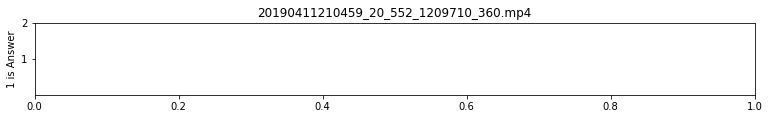

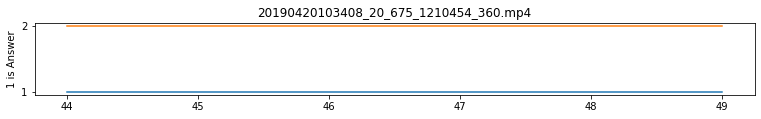

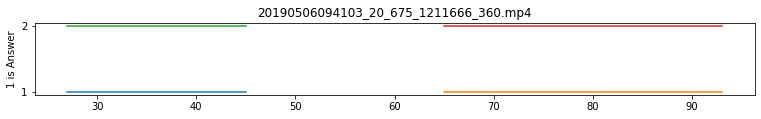

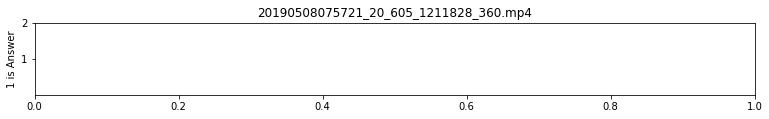

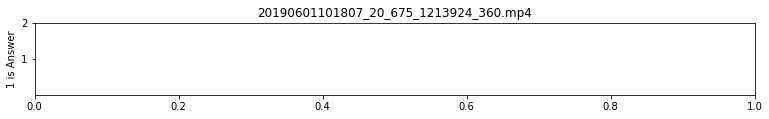

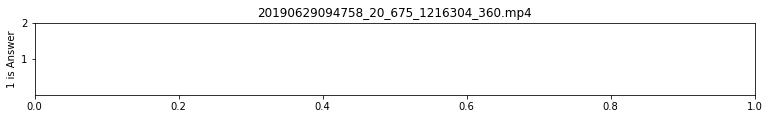

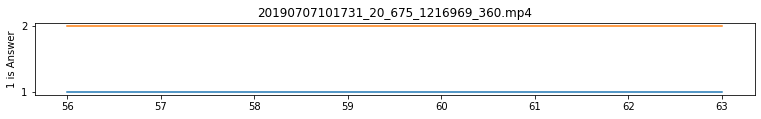

In [ ]:
# 구간 그래프

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

for key in answer_json.keys():
  fig = plt.figure(figsize=(10,1))
  ax = fig.add_axes([0,0,1,1])

  answer_scene = answer_json[key]['scenes']
  compare_scene = compare_json[key]['scenes']
  duration = int(answer_json[key]['duration'])
  name = key

  answer_x = []
  answer_y = []

  compare_x = []
  compare_y = []

  for i, xs in enumerate(answer_scene):
    now = list(np.arange(xs[0], xs[1] + 1))
    answer_x.append(now)
    answer_y.append([1] * len(now))

  for i, xs in enumerate(compare_scene):
    now = list(np.arange(xs[0], xs[1] + 1))
    compare_x.append(now)
    compare_y.append([2] * len(now))
    
  for line in zip(answer_x, answer_y):
    plt.plot(line[0], line[1], label = "Answer")

  for line in zip(compare_x, compare_y):
    plt.plot(line[0], line[1], label = "Compare")

  ax.set_yticks([1,2])
  plt.ylabel('1 is Answer') 
  plt.title(name)
  plt.show()

In [ ]:
# 간단한 비교
# 각 Key에 대한 IoU를 따로 계산하지 않고, 모든 Scene이 얼마나 일치하는지를 비교함

# 일치하는 구간이 많을수록 정확도는 높으나, 구간이 나눠져있을때의 점수 감소는 반영되지 않음

match = 0
mismatch = 0
count = 0

for key in answer_unjson.keys():
  tmp_match = 0
  tmp_mismatch = 0

  duration = len(answer_unjson[key])
  count += duration
  previous = None

  for i in range(0, duration):
    now = answer_unjson[key][i]
    now_compare = compare_unjson[key][i]

    if now:
      if now_compare:
        tmp_match += 1
      elif not now_compare:
        tmp_mismatch += 1
    else:
      if now:
        tmp_mismatch += 1
      elif not now_compare:
        tmp_match += 1 
    
    previous = now

  match += tmp_match
  mismatch += tmp_mismatch

percent = (match - mismatch) / count

print('Total count : ', count)
print('Match count : ', match)
print('Mismatch count : ', mismatch)
print('Simility : ', percent)
print('Simple Estimation : ', answer_percent * percent)

Total count :  6274
Match count :  6274
Mismatch count :  0
Simility :  1.0
Simple Estimation :  0.65
